In [41]:
import pyspark
import pandas as pd
import numpy as np
import math

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, mean, column
import matplotlib.pyplot as plt
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row
from pyspark.mllib.recommendation import ALS

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd


In [42]:
spark = SparkSession.builder.appName("PCAExample1").getOrCreate()

In [43]:
df_raw = spark.read.csv("wildfire100.csv" , header = True, inferSchema = True)
column_names = df_raw.columns

df_raw = df_raw.drop("acq_date")
df_raw = df_raw.dropna()

In [44]:
feature_columns = df_raw.columns
assembler = VectorAssembler(inputCols = feature_columns, outputCol =  "features")
assembled_data = assembler.transform(df_raw)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)

scaled_data = scaler_model.transform(assembled_data)

In [45]:
pca = PCA(k=10, inputCol="scaled_features", outputCol="pcaFeatues")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

In [46]:
explained_variance = model.explainedVariance
print ("Explained Variance:", sum(explained_variance))


Explained Variance: 0.7304159491523798


In [47]:
# Extract PCA loadings
# Assuming pca_model is the name of your PCA model instance
loadings = model.pc.toArray()

# For simplicity, let's analyze the loadings for the first principal component
pc1_loadings = loadings[:, 0]

# Pair the loadings with feature names and sort
feature_importance = sorted(list(zip(feature_columns, pc1_loadings)), key=lambda x: x[1], reverse=True)

for feature, loading in feature_importance:
    print(f"{feature}: {loading}")


FVT2016_max: 0.07069214158049915
Neighbour_FVT2016_max: 0.06921447569863778
FVT2016_mode: 0.06852287418223002
Neighbour_FVT2016_mode: 0.06800202897200021
Neighbour_EVT2012_mean: 0.06710263298220549
Neighbour_EVT2014_mean: 0.06706577986083162
EVT2012_mean: 0.0669135862914187
EVT2014_mean: 0.06689620546555251
NVC2016_mean: 0.06506696440513077
Neighbour_NVC2016_mean: 0.06427829917037783
EVT2014_median: 0.06318411898208783
EVT2012_median: 0.0631710046416644
Neighbour_EVT2014_max: 0.06313440390559338
Neighbour_EVT2012_max: 0.06301158780349675
Neighbour_EVT2012_median: 0.06269977103711649
Neighbour_EVT2014_median: 0.06269526191386686
EVT2014_max: 0.061784585833896025
EVT2012_max: 0.06160123834152568
NVC2016_min: 0.06053719868022073
FVT2016_mean: 0.06012457127504182
Neighbour_FVT2016_mean: 0.058480096211257264
Neighbour_NVC2016_min: 0.05830324733911521
FVT2016_sum: 0.05717050780174379
FVT2016_median: 0.05696919734620822
NVC2016_median: 0.05681124906753015
NVC2016_sum: 0.05668905558789385
Neig

In [48]:
num_cluster_centers = 10

kmean = KMeans(featuresCol= "scaled_features").setK(num_cluster_centers).setSeed(1)

model= kmean.fit(scaled_data)

cluster_centers = model.clusterCenters()
clustered_data = model.transform(scaled_data)

evaluator = ClusteringEvaluator()
silhouetter_score = evaluator.evaluate(clustered_data)

wcss = model.summary.trainingCost

cluster_sizes = clustered_data.groupBy("prediction").count()
cluster_sizes.show()


+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2942|
|         6| 2317|
|         3| 2275|
|         5| 2391|
|         9| 8640|
|         4| 4136|
|         8| 6220|
|         7| 2611|
|         2| 1290|
|         0| 6614|
+----------+-----+



In [49]:
cluster_profiles = clustered_data.groupBy('prediction').mean().collect()

for row in cluster_profiles:
    print(f"Cluster {row['prediction']}:")
    for feature in feature_columns:
        print(f"{feature}: {row['avg(' + feature + ')']}")
    print("\n")

Cluster 1:
Polygon_ID: 1633165.2542488102
frp: 10.624819283933832
Neighbour: 1632900.9830047586
Neighbour_frp: 2.0266003852254704
CBC2014_max: 44.04078857919782
CBC2014_min: 2.8235893949694084
CBC2014_median: 10.301155676410605
CBC2014_sum: 1958.384772263766
CBC2014_mode: 4.1781101291638345
CBC2014_count: 150.23283480625426
CBC2014_mean: 13.022009225814413
CBD2012_max: 18.359279401767505
CBD2012_min: 2.696464989802855
CBD2012_median: 10.443745751189667
CBD2012_sum: 1546.6145479265806
CBD2012_mode: 4.535690006798097
CBD2012_count: 150.23283480625426
CBD2012_mean: 10.292931657851803
CBD2016_max: 18.036369816451394
CBD2016_min: 2.5577838205302514
CBD2016_median: 9.860978925900747
CBD2016_sum: 1475.5771583956491
CBD2016_mode: 4.357239972807614
CBD2016_count: 150.2324949014276
CBD2016_mean: 9.82492614463562
CBH2012_max: 43.10673011556764
CBH2012_min: 3.19306594153637
CBH2012_median: 9.574779061862678
CBH2012_sum: 1867.1312032630863
CBH2012_mode: 4.583276682528892
CBH2012_count: 150.23283480

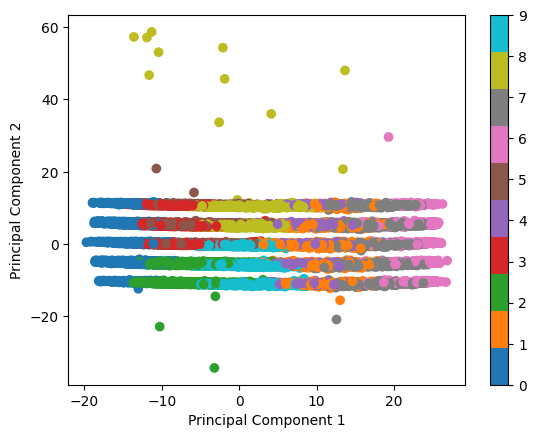

In [50]:
# First, apply KMeans clustering on the PCA results
kmean = KMeans(featuresCol="pcaFeatues", k=num_cluster_centers).setSeed(1)
kmeans_model = kmean.fit(result)
clustered_data = kmeans_model.transform(result)

# Extract PCA values and predictions
pca_values = clustered_data.select("pcaFeatues", "prediction").collect()
x = [row['pcaFeatues'][0] for row in pca_values]
y = [row['pcaFeatues'][1] for row in pca_values]
colors = [row['prediction'] for row in pca_values]

# Plotting
plt.scatter(x, y, c=colors, cmap='tab10')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


In [52]:
# Extract PCA values and predictions
# 2. Run KMeans clustering on the PCA-transformed data
kmean = KMeans(featuresCol="pcaFeatures", k=num_cluster_centers).setSeed(1)
kmeans_model = kmean.fit(result)
clustered_data = kmeans_model.transform(result)

# Confirming that the 'prediction' column exists
clustered_data.show()

# 3. Visualize the clusters using the first two principal components
pca_values = clustered_data.select("pcaFeatures", "prediction").collect()
x = [row['pcaFeatures'][0] for row in pca_values]
y = [row['pcaFeatures'][1] for row in pca_values]
colors = [row['prediction'] for row in pca_values]

plt.scatter(x, y, c=colors, cmap='tab10')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


23/10/30 20:25:34 ERROR Instrumentation: java.lang.IllegalArgumentException: pcaFeatures does not exist. Available: Polygon_ID, frp, Neighbour, Neighbour_frp, CBC2014_max, CBC2014_min, CBC2014_median, CBC2014_sum, CBC2014_mode, CBC2014_count, CBC2014_mean, CBD2012_max, CBD2012_min, CBD2012_median, CBD2012_sum, CBD2012_mode, CBD2012_count, CBD2012_mean, CBD2016_max, CBD2016_min, CBD2016_median, CBD2016_sum, CBD2016_mode, CBD2016_count, CBD2016_mean, CBH2012_max, CBH2012_min, CBH2012_median, CBH2012_sum, CBH2012_mode, CBH2012_count, CBH2012_mean, CBH2014_max, CBH2014_min, CBH2014_median, CBH2014_sum, CBH2014_mode, CBH2014_count, CBH2014_mean, CBH2016_max, CBH2016_min, CBH2016_median, CBH2016_sum, CBH2016_mode, CBH2016_count, CBH2016_mean, CC2012_max, CC2012_min, CC2012_median, CC2012_sum, CC2012_mode, CC2012_count, CC2012_mean, CC2014_max, CC2014_min, CC2014_median, CC2014_sum, CC2014_mode, CC2014_count, CC2014_mean, CC2016_max, CC2016_min, CC2016_median, CC2016_sum, CC2016_mode, CC2016_

IllegalArgumentException: pcaFeatures does not exist. Available: Polygon_ID, frp, Neighbour, Neighbour_frp, CBC2014_max, CBC2014_min, CBC2014_median, CBC2014_sum, CBC2014_mode, CBC2014_count, CBC2014_mean, CBD2012_max, CBD2012_min, CBD2012_median, CBD2012_sum, CBD2012_mode, CBD2012_count, CBD2012_mean, CBD2016_max, CBD2016_min, CBD2016_median, CBD2016_sum, CBD2016_mode, CBD2016_count, CBD2016_mean, CBH2012_max, CBH2012_min, CBH2012_median, CBH2012_sum, CBH2012_mode, CBH2012_count, CBH2012_mean, CBH2014_max, CBH2014_min, CBH2014_median, CBH2014_sum, CBH2014_mode, CBH2014_count, CBH2014_mean, CBH2016_max, CBH2016_min, CBH2016_median, CBH2016_sum, CBH2016_mode, CBH2016_count, CBH2016_mean, CC2012_max, CC2012_min, CC2012_median, CC2012_sum, CC2012_mode, CC2012_count, CC2012_mean, CC2014_max, CC2014_min, CC2014_median, CC2014_sum, CC2014_mode, CC2014_count, CC2014_mean, CC2016_max, CC2016_min, CC2016_median, CC2016_sum, CC2016_mode, CC2016_count, CC2016_mean, CH2012_max, CH2012_min, CH2012_median, CH2012_sum, CH2012_mode, CH2012_count, CH2012_mean, CH2014_max, CH2014_min, CH2014_median, CH2014_sum, CH2014_mode, CH2014_count, CH2014_mean, CH2016_max, CH2016_min, CH2016_median, CH2016_sum, CH2016_mode, CH2016_count, CH2016_mean, ELEV2016_max, ELEV2016_min, ELEV2016_median, ELEV2016_sum, ELEV2016_mode, ELEV2016_count, ELEV2016_mean, EVC2012_max, EVC2012_min, EVC2012_median, EVC2012_sum, EVC2012_mode, EVC2012_count, EVC2012_mean, EVC2014_max, EVC2014_min, EVC2014_median, EVC2014_sum, EVC2014_mode, EVC2014_count, EVC2014_mean, EVC2016_max, EVC2016_min, EVC2016_median, EVC2016_sum, EVC2016_mode, EVC2016_count, EVC2016_mean, EVH2012_max, EVH2012_min, EVH2012_median, EVH2012_sum, EVH2012_mode, EVH2012_count, EVH2012_mean, EVH2014_max, EVH2014_min, EVH2014_median, EVH2014_sum, EVH2014_mode, EVH2014_count, EVH2014_mean, EVH2016_max, EVH2016_min, EVH2016_median, EVH2016_sum, EVH2016_mode, EVH2016_count, EVH2016_mean, EVT2012_max, EVT2012_min, EVT2012_median, EVT2012_sum, EVT2012_mode, EVT2012_count, EVT2012_mean, EVT2014_max, EVT2014_min, EVT2014_median, EVT2014_sum, EVT2014_mode, EVT2014_count, EVT2014_mean, EVT2016_max, EVT2016_min, EVT2016_median, EVT2016_sum, EVT2016_mode, EVT2016_count, EVT2016_mean, FCCS2014_max, FCCS2014_min, FCCS2014_median, FCCS2014_sum, FCCS2014_mode, FCCS2014_count, FCCS2014_mean, FVC2016_max, FVC2016_min, FVC2016_median, FVC2016_sum, FVC2016_mode, FVC2016_count, FVC2016_mean, FVH2016_max, FVH2016_min, FVH2016_median, FVH2016_sum, FVH2016_mode, FVH2016_count, FVH2016_mean, FVT2016_max, FVT2016_min, FVT2016_median, FVT2016_sum, FVT2016_mode, FVT2016_count, FVT2016_mean, NVC2016_max, NVC2016_min, NVC2016_median, NVC2016_sum, NVC2016_mode, NVC2016_count, NVC2016_mean, SLP2016_max, SLP2016_min, SLP2016_median, SLP2016_sum, SLP2016_mode, SLP2016_count, SLP2016_mean, Neighbour_CBC2014_max, Neighbour_CBC2014_min, Neighbour_CBC2014_median, Neighbour_CBC2014_sum, Neighbour_CBC2014_mode, Neighbour_CBC2014_count, Neighbour_CBC2014_mean, Neighbour_CBD2012_max, Neighbour_CBD2012_min, Neighbour_CBD2012_median, Neighbour_CBD2012_sum, Neighbour_CBD2012_mode, Neighbour_CBD2012_count, Neighbour_CBD2012_mean, Neighbour_CBD2016_max, Neighbour_CBD2016_min, Neighbour_CBD2016_median, Neighbour_CBD2016_sum, Neighbour_CBD2016_mode, Neighbour_CBD2016_count, Neighbour_CBD2016_mean, Neighbour_CBH2012_max, Neighbour_CBH2012_min, Neighbour_CBH2012_median, Neighbour_CBH2012_sum, Neighbour_CBH2012_mode, Neighbour_CBH2012_count, Neighbour_CBH2012_mean, Neighbour_CBH2014_max, Neighbour_CBH2014_min, Neighbour_CBH2014_median, Neighbour_CBH2014_sum, Neighbour_CBH2014_mode, Neighbour_CBH2014_count, Neighbour_CBH2014_mean, Neighbour_CBH2016_max, Neighbour_CBH2016_min, Neighbour_CBH2016_median, Neighbour_CBH2016_sum, Neighbour_CBH2016_mode, Neighbour_CBH2016_count, Neighbour_CBH2016_mean, Neighbour_CC2012_max, Neighbour_CC2012_min, Neighbour_CC2012_median, Neighbour_CC2012_sum, Neighbour_CC2012_mode, Neighbour_CC2012_count, Neighbour_CC2012_mean, Neighbour_CC2014_max, Neighbour_CC2014_min, Neighbour_CC2014_median, Neighbour_CC2014_sum, Neighbour_CC2014_mode, Neighbour_CC2014_count, Neighbour_CC2014_mean, Neighbour_CC2016_max, Neighbour_CC2016_min, Neighbour_CC2016_median, Neighbour_CC2016_sum, Neighbour_CC2016_mode, Neighbour_CC2016_count, Neighbour_CC2016_mean, Neighbour_CH2012_max, Neighbour_CH2012_min, Neighbour_CH2012_median, Neighbour_CH2012_sum, Neighbour_CH2012_mode, Neighbour_CH2012_count, Neighbour_CH2012_mean, Neighbour_CH2014_max, Neighbour_CH2014_min, Neighbour_CH2014_median, Neighbour_CH2014_sum, Neighbour_CH2014_mode, Neighbour_CH2014_count, Neighbour_CH2014_mean, Neighbour_CH2016_max, Neighbour_CH2016_min, Neighbour_CH2016_median, Neighbour_CH2016_sum, Neighbour_CH2016_mode, Neighbour_CH2016_count, Neighbour_CH2016_mean, Neighbour_ELEV2016_max, Neighbour_ELEV2016_min, Neighbour_ELEV2016_median, Neighbour_ELEV2016_sum, Neighbour_ELEV2016_mode, Neighbour_ELEV2016_count, Neighbour_ELEV2016_mean, Neighbour_EVC2012_max, Neighbour_EVC2012_min, Neighbour_EVC2012_median, Neighbour_EVC2012_sum, Neighbour_EVC2012_mode, Neighbour_EVC2012_count, Neighbour_EVC2012_mean, Neighbour_EVC2014_max, Neighbour_EVC2014_min, Neighbour_EVC2014_median, Neighbour_EVC2014_sum, Neighbour_EVC2014_mode, Neighbour_EVC2014_count, Neighbour_EVC2014_mean, Neighbour_EVC2016_max, Neighbour_EVC2016_min, Neighbour_EVC2016_median, Neighbour_EVC2016_sum, Neighbour_EVC2016_mode, Neighbour_EVC2016_count, Neighbour_EVC2016_mean, Neighbour_EVH2012_max, Neighbour_EVH2012_min, Neighbour_EVH2012_median, Neighbour_EVH2012_sum, Neighbour_EVH2012_mode, Neighbour_EVH2012_count, Neighbour_EVH2012_mean, Neighbour_EVH2014_max, Neighbour_EVH2014_min, Neighbour_EVH2014_median, Neighbour_EVH2014_sum, Neighbour_EVH2014_mode, Neighbour_EVH2014_count, Neighbour_EVH2014_mean, Neighbour_EVH2016_max, Neighbour_EVH2016_min, Neighbour_EVH2016_median, Neighbour_EVH2016_sum, Neighbour_EVH2016_mode, Neighbour_EVH2016_count, Neighbour_EVH2016_mean, Neighbour_EVT2012_max, Neighbour_EVT2012_min, Neighbour_EVT2012_median, Neighbour_EVT2012_sum, Neighbour_EVT2012_mode, Neighbour_EVT2012_count, Neighbour_EVT2012_mean, Neighbour_EVT2014_max, Neighbour_EVT2014_min, Neighbour_EVT2014_median, Neighbour_EVT2014_sum, Neighbour_EVT2014_mode, Neighbour_EVT2014_count, Neighbour_EVT2014_mean, Neighbour_EVT2016_max, Neighbour_EVT2016_min, Neighbour_EVT2016_median, Neighbour_EVT2016_sum, Neighbour_EVT2016_mode, Neighbour_EVT2016_count, Neighbour_EVT2016_mean, Neighbour_FCCS2014_max, Neighbour_FCCS2014_min, Neighbour_FCCS2014_median, Neighbour_FCCS2014_sum, Neighbour_FCCS2014_mode, Neighbour_FCCS2014_count, Neighbour_FCCS2014_mean, Neighbour_FVC2016_max, Neighbour_FVC2016_min, Neighbour_FVC2016_median, Neighbour_FVC2016_sum, Neighbour_FVC2016_mode, Neighbour_FVC2016_count, Neighbour_FVC2016_mean, Neighbour_FVH2016_max, Neighbour_FVH2016_min, Neighbour_FVH2016_median, Neighbour_FVH2016_sum, Neighbour_FVH2016_mode, Neighbour_FVH2016_count, Neighbour_FVH2016_mean, Neighbour_FVT2016_max, Neighbour_FVT2016_min, Neighbour_FVT2016_median, Neighbour_FVT2016_sum, Neighbour_FVT2016_mode, Neighbour_FVT2016_count, Neighbour_FVT2016_mean, Neighbour_NVC2016_max, Neighbour_NVC2016_min, Neighbour_NVC2016_median, Neighbour_NVC2016_sum, Neighbour_NVC2016_mode, Neighbour_NVC2016_count, Neighbour_NVC2016_mean, Neighbour_SLP2016_max, Neighbour_SLP2016_min, Neighbour_SLP2016_median, Neighbour_SLP2016_sum, Neighbour_SLP2016_mode, Neighbour_SLP2016_count, Neighbour_SLP2016_mean, features, scaled_features, pcaFeatues